#Capstone Project
##Full Name : Samuel Baguma
##Email Address: kabsam99@gmail.com
##Problem Statement of Submission :
###AI-Driven Medical Assistant (MediBot)

#Step 1 — Installing pre-requistites

In [1]:
# Installing required packages
!pip install langchainhub
!pip install langchain-openai
!pip install langchain
!pip install beautifulsoup4
!pip install langchain-community
!pip install faiss-cpu
!pip install -U langchain-community tavily-python
!pip gradio_client
!pip install gradio
!pip install langchain_community
!pip install --upgrade langchain langchain-community langchain-openai
#!pip install langchain-text-splitter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 58.1 MB/s eta 0:00:00
ERROR: unknown command "gradio_client"
ERROR: Could not find a version that satisfies the requirement langchain-text-splitter (from versions: none)
ERROR: No matching distribution found for langchain-text-splitter


In [2]:
# Necessary Imports
#import kagglehub
import csv
import pandas as pd
import math
import numpy as np
import os
import getpass
from langchain_core.output_parsers import StrOutputParser
from google.colab import drive

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain.agents import create_openai_functions_agent
from langchain.chains.combine_documents import create_stuff_documents_chain

# Perform necessary imports for creating agents
from langchain import hub # Used to pull predefined prompts from LangChain Hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain.memory import ChatMessageHistory  # Used to store chat history in memory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import OpenAI

In [3]:
# Setting up Open AI key
os.environ["OPENAI_API_KEY"] = getpass.getpass()
#Open_API_Key = os.getenv("Open_API_Key")
#os.environ["OPENAI_API_KEY"] = Open_API_Key

··········


#Step 2 — Load the Data

In [4]:
# Loading and merging the disease symptom dataset
drive.mount("/content/gdrive")

symptom_df = pd.read_csv("/content/gdrive/MyDrive/ML/Medibot/dataset.csv")
description_df = pd.read_csv("/content/gdrive/MyDrive/ML/Medibot/symptom_Description.csv")
precaution_df = pd.read_csv("/content/gdrive/MyDrive/ML/Medibot/symptom_precaution.csv")
severity_df = pd.read_csv("/content/gdrive/MyDrive/ML/Medibot/Symptom-severity.csv")

Mounted at /content/gdrive


# Step 3 — Merge Disease-Level Info (Symptom, Description, Precaution)

In [5]:
#Merge description and precaution on Disease
disease_info = symptom_df.merge(description_df, on='Disease', how='left') \
                         .merge(precaution_df, on='Disease', how='left')

disease_info = disease_info.fillna('')

In [171]:
disease_info.columns

Index(['Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4',
       'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9',
       'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14',
       'Symptom_15', 'Symptom_16', 'Symptom_17', 'Description', 'Precaution_1',
       'Precaution_2', 'Precaution_3', 'Precaution_4'],
      dtype='object')

In [173]:

# List of symptom columns
symptom_cols = [f'Symptom_{i}' for i in range(1, 18)]

# Melt the DataFrame to have 'Symptom' in a single column
symptoms_long = disease_info.melt(
    id_vars=['Disease'],
    value_vars=symptom_cols,
    var_name='Symptom_Number',
    value_name='Symptom'
)

# Drop NaNs or empty symptoms
symptoms_long = symptoms_long.dropna(subset=['Symptom'])
symptoms_long = symptoms_long[symptoms_long['Symptom'].str.strip() != '']

# Group by symptom and count unique diseases
symptom_disease_counts = symptoms_long.groupby('Symptom')['Disease'].nunique().reset_index()
symptom_disease_counts = symptom_disease_counts.sort_values(by='Disease', ascending=False)

# Display top 10 symptoms with most shared diseases
print(symptom_disease_counts.head(10))

                Symptom  Disease
41              fatigue       17
120            vomiting       17
45           high_fever       12
70               nausea       10
44             headache       10
59     loss_of_appetite       10
0        abdominal_pain        9
129      yellowish_skin        8
128   yellowing_of_eyes        7
99            skin_rash        7


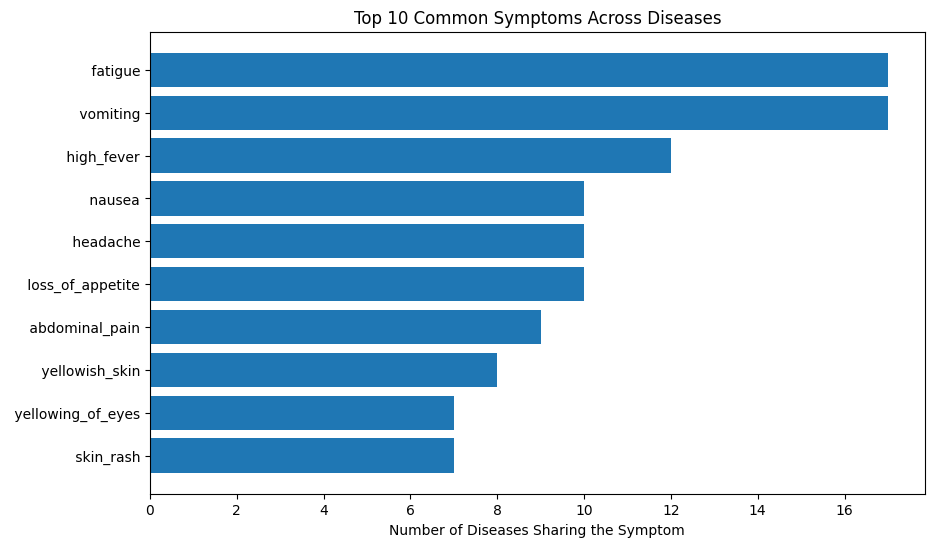

In [174]:
import matplotlib.pyplot as plt

top_symptoms = symptom_disease_counts.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_symptoms['Symptom'], top_symptoms['Disease'])
plt.xlabel('Number of Diseases Sharing the Symptom')
plt.title('Top 10 Common Symptoms Across Diseases')
plt.gca().invert_yaxis()
plt.show()

In [175]:
print(f"Total unique symptoms: {symptom_disease_counts.shape[0]}")


Total unique symptoms: 131


In [176]:
unique_symptoms = symptom_disease_counts[symptom_disease_counts['Disease'] == 1]
print(f"Symptoms unique to one disease: {unique_symptoms.shape[0]}")


Symptoms unique to one disease: 80


#Step 4 — Prepare Combined Text + Metadata for Each Disease

In [6]:
texts = []
metadatas = []

for _, row in disease_info.iterrows():
    # Gather all symptoms in one list
    symptoms = [row[f'Symptom_{i}'] for i in range(1, 18) if row.get(f'Symptom_{i}')]

    # Fetch severity weights for each symptom (if available)
    symptom_severity_list = []
    for s in symptoms:
        weight = severity_df[severity_df['Symptom'] == s]['weight'].values
        weight_str = str(weight[0]) if len(weight) > 0 else 'Unknown'
        symptom_severity_list.append(f"{s} (Severity: {weight_str})")

    # Gather all precautions in one list
    precautions = [row.get(f'Precaution_{i}', '') for i in range(1, 5) if row.get(f'Precaution_{i}')]

    # Prepare the combined text
    combined_text = f"Disease: {row['Disease']}\n" \
                    f"Description: {row['Description']}\n" \
                    f"Symptoms:\n" + "\n".join(symptom_severity_list) + "\n" \
                    f"Precautions:\n" + "\n".join(precautions)

    texts.append(combined_text)
    metadatas.append({
        "disease": row['Disease'],
        "description": row['Description'],
        "symptoms": symptoms,
        "precautions": precautions
    })


#Step 5 — Create FAISS Vector Store

In [7]:
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_texts(texts, embeddings, metadatas=metadatas)

In [8]:
#save store local
vectorstore.save_local('disease_faiss_store')

In [9]:
#load local store

embeddings = OpenAIEmbeddings()
vectorstore = FAISS.load_local('disease_faiss_store', embeddings, allow_dangerous_deserialization=True)

#retriever = vectorstore.as_retriever()

In [10]:
# Create ChatOpenAI object for acting as an LLM.
# See https://python.langchain.com/docs/integrations/chat/openai/
llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"], temperature=0)

# Create a prompt template that gives the model a persona of a customer
# Create a chain for passing a list of Documents to a model.
output_parser = StrOutputParser()
prompt = ChatPromptTemplate.from_template("""Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}""", output_parser = output_parser)

document_chain = create_stuff_documents_chain(llm, prompt)
# document_chain = prompt | llm

# Creating a retriever
# See https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/vectorstore/
retriever = vectorstore.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)

#Step 6 — Running some test cases

In [11]:
# Invoke the retrieval chain to process the user's query
# Invoking the retrieval chain to process the user's query.
# The query "what are some of the best shoes available?" is passed as input.
# The retrieval chain first fetches relevant  information from the vector store,
# then processes them using the document chain to generate a meaningful AI response.
retrieval_chain.invoke({"input": "what are the symptoms of malaria?"})['answer']

# Example 1: Symptom Check
response1 = retrieval_chain.invoke({"input": "I feel feverish with body aches and sore throat"})
print("🩺 Symptom Checker:\n", response1['answer'])

# Example 2: Precaution Advisor
response2 = retrieval_chain.invoke({"input": "What should I do if I have high fever and cough?"})
print("💊 Precaution Advisor:\n", response2['answer'])

# Example 3: Severity Risk Estimator
response3 = retrieval_chain.invoke({"input": "Assess risk for headache, nausea, vomiting"})
print("🚨 Severity Risk Estimator:\n", response3['answer'])

# Example 4: Symptom to Disease Matching
response4 = retrieval_chain.invoke({"input": "I have fatigue and sore throat"})
print("🔍 Symptom Matcher:\n", response4['answer'])

# Example 5: FAQ on Disease
response5 = retrieval_chain.invoke({"input": "Tell me about Dengue"})
print("📚 FAQ Disease Info:\n", response5['answer'])


🩺 Symptom Checker:
 Based on the provided context, it is likely that you have symptoms of the common cold. To alleviate your symptoms, you should drink vitamin C rich drinks, take vapor, avoid cold food, and keep your fever in check.
💊 Precaution Advisor:
 If you have high fever and cough, you should drink vitamin C rich drinks, take vapor, avoid cold food, and keep your fever in check.
🚨 Severity Risk Estimator:
 Based on the provided context, the risk for headache, nausea, and vomiting is high as these symptoms are common indicators of a migraine. The description of a migraine includes severe throbbing pain or pulsing sensation on one side of the head, accompanied by nausea and vomiting. Additionally, the symptoms listed for migraine include headache, which further supports the high risk for experiencing these symptoms. It is important to take precautions such as meditation, stress reduction, using polaroid glasses in the sun, and consulting a doctor to manage and potentially prevent

In [12]:
# Perform adequate formatting to print the final response in a user readable format
# Function to process the user query and return formatted information
def final_response(user_query):
    # Invoking the retrieval chain with the user's query to fetch relevant information
    response = retrieval_chain.invoke({"input": user_query})['answer']

    # Creating a prompt to instruct the AI to format the response properly
    # The prompt asks the AI to extract only information from the retrieved response
    prompt = f"Format the responses properly in {response}. Just return the disease symptoms, precautions or severity, no other text"

    # Sending the formatted prompt to the GPT-4o-mini model for processing
    openai_response = client.chat.completions.create(
        model='gpt-4o-mini',  # Using GPT-4o-mini model for response generation
        messages=[{'role': 'user', 'content': prompt}]  # Providing the prompt to the model
    )

    # Extracting and returning the AI-generated response containing only the disease information
    return openai_response.choices[0].message.content

In [14]:
# Creating an instance of the OpenAI client using the provided API key.
# Importing the OpenAI library to interact with OpenAI's API services.
from openai import OpenAI
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
client = OpenAI(api_key=OPENAI_API_KEY)

In [15]:
# Printing the final response
print(final_response("what are the symptoms of swine fever?"))

**Symptoms of Swine Fever:**
- High fever
- Lack of appetite
- Depression
- Skin lesions or discoloration
- Coughing
- Difficulty breathing
- Abortion in pregnant sows
- Sudden death

**Precautions:**
- Quarantine infected animals
- Implement strict biosecurity measures
- Control the movement of animals and equipment
- Vaccination (where applicable)
- Proper disposal of carcasses

**Severity:**
- Highly contagious
- Often leads to high mortality rates in pigs
- Can cause significant economic losses in affected industries


#Step 7 — Define the Tools

In [160]:
from langchain_core.tools import tool
from langchain.tools.render import render_text_description
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import JsonOutputParser
from langchain.memory import ConversationSummaryMemory
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

@tool
def symptom_checker_tool(symptom_query: str) -> str:
    """Search for diseases based on described symptoms."""
    results = vectorstore.similarity_search(symptom_query, k=3)
    if not results:
        return "No matching diseases found."

    response = "Here are some possible diseases based on your symptoms:\n\n"
    for doc in results:
        response += f"{doc.page_content}\n\n"
    return response

@tool
def precaution_advisor(symptom_query: str) -> str:
    """Advise on precautions based on described symptoms. Use this tool when a patient asks what they should do."""

    results = retriever.get_relevant_documents(symptom_query)
    if not results:
        return "No diseases or precautions found related to your symptoms."

    response = "Recommended precautions based on your symptoms:\n\n"
    for doc in results:
        metadata = doc.metadata
        precautions = metadata.get('precautions', [])
        if precautions:
            response += f"- Disease: {metadata.get('disease')}\n"
            for p in precautions:
                if p:
                    response += f"  • {p}\n"
            response += "\n"
    return response.strip() if response.strip() else "No precautions available."

@tool
def severity_risk_estimator(symptom_list: str) -> str:
    """Estimate severity risk based on a list of symptoms."""
    symptoms = [s.strip() for s in symptom_list.split(',')]
    total_severity = 0
    known_symptoms = 0

    for s in symptoms:
        matching = retriever.get_relevant_documents(s)
        for doc in matching:
            for sym in doc.metadata.get('symptoms', []):
                if s.lower() in sym.lower():
                    known_symptoms += 1
                    # Assuming you stored severity as int in metadata
                    severity = int(doc.metadata.get('severity', 1))
                    total_severity += severity

    if known_symptoms == 0:
        return "No known symptoms found. Unable to assess severity."

    avg_severity = total_severity / known_symptoms
    if avg_severity < 2:
        risk = "Low"
    elif avg_severity < 4:
        risk = "Medium"
    else:
        risk = "High"

    return f"Based on the provided symptoms, the estimated risk is: **{risk}** (Average Severity Score: {avg_severity:.2f})"

@tool
def symptom_to_disease_matcher(symptoms_query: str) -> str:
    """Find diseases matching multiple symptoms."""
    results = retriever.get_relevant_documents(symptoms_query)
    if not results:
        return "No diseases matched the provided symptoms."

    response = "Possible diseases matching your symptoms:\n\n"
    for doc in results:
        disease = doc.metadata.get('disease', 'Unknown Disease')
        response += f"- {disease}: {doc.metadata.get('description', '')}\n"

    return response.strip()

@tool
def faq_disease_info(disease_name: str) -> str:
    """Get detailed information about a specific disease."""
    results = retriever.get_relevant_documents(disease_name)
    if not results:
        return f"No information found for {disease_name}."

    doc = results[0]
    description = doc.metadata.get('description', 'No description available.')
    symptoms = ", ".join(doc.metadata.get('symptoms', []))
    precautions = ", ".join(doc.metadata.get('precautions', []))

    return (f"Disease: {disease_name}\n\n"
            f"Description: {description}\n\n"
            f"Symptoms: {symptoms}\n\n"
            f"Precautions: {precautions}")



# Step 8 — Adding memory and create an agent

In [161]:
from langchain_core.tools import tool
from langchain.tools.render import render_text_description # Not strictly needed but keeping import
from operator import itemgetter # Not strictly needed but keeping import
from langchain_core.runnables import RunnablePassthrough # Not strictly needed but keeping import
from langchain_core.output_parsers import JsonOutputParser # Not strictly needed but keeping import
from langchain.memory import ConversationSummaryMemory # Not strictly needed but keeping import for now
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder # Keeping imports
from langchain.agents import create_openai_functions_agent, AgentExecutor

# Import necessary components for initialize_agent
from langchain.agents import AgentExecutor, initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory # Use ConversationBufferMemory for memory

# Import LLM and other necessary modules
from langchain_openai import ChatOpenAI
import os
import getpass

# Assuming tools are defined in a previous cell like a76946d1 or iyAi5nTHK75z
# List of tools (ensure these are defined before this cell or within it)
tools = [symptom_checker_tool,
        precaution_advisor,
        severity_risk_estimator,
        symptom_to_disease_matcher,
        faq_disease_info]

# Setting up Open AI key (ensure this is run before initializing LLM)
# os.environ["OPENAI_API_KEY"] = getpass.getpass() # Assuming this is handled elsewhere or set as secret

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0, openai_api_key=os.environ["OPENAI_API_KEY"])

# Initialize memory
memory = ConversationBufferMemory(
    llm=llm,
    memory_key="chat_history",
    return_messages=True
)

# Define a custom prompt to strictly restrict output to tool results - Further refinement
custom_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a helpful health assistant whose knowledge is strictly limited to the information accessible through the provided tools. "
     "Your sole purpose is to retrieve information from your tools and present it to the user. "
     "You MUST use the provided tools to answer ALL user questions that are relevant to health or symptoms. "
     "You MUST ONLY provide information that is directly returned by a tool. "
     "If a tool call does not return relevant information for the user's query, or if the user's query is outside the scope of your tools, you MUST respond with the exact phrase: 'I cannot find information on that topic using my available tools.' "
     "DO NOT provide any other information or generate responses based on general knowledge if a tool is not successfully used to find an answer."
    ),
    MessagesPlaceholder("chat_history"), # Include chat history for memory
    ("human", "{input}"),
    MessagesPlaceholder("agent_scratchpad") # Required for the agent's intermediate steps
])


# Create the agent using initialize_agent with OPENAI_FUNCTIONS
# Pass the system message from the custom prompt using agent_kwargs
agent = create_openai_functions_agent(
    llm=llm,
    tools=tools,
    prompt=custom_prompt
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    memory=memory,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=15
)

# Test cases (example usage - remove or comment out for final notebook)
# print(agent_executor.invoke({"input": "I have a headache and a runny nose."}))

#Step 9 — Run some tests

In [162]:
response1 = agent_executor.invoke({"input": "I feel feverish with body aches and sore throat"})
print("🩺 Symptom Checker:\n", response1['output'])



> Entering new AgentExecutor chain...

Invoking: `symptom_checker_tool` with `{'symptom_query': 'feverish, body aches, sore throat'}`


Here are some possible diseases based on your symptoms:

Disease: Dengue
Description: an acute infectious disease caused by a flavivirus (species Dengue virus of the genus Flavivirus), transmitted by aedes mosquitoes, and characterized by headache, severe joint pain, and a rash. — called also breakbone fever, dengue fever.
Symptoms:
 chills (Severity: Unknown)
 joint_pain (Severity: Unknown)
 vomiting (Severity: Unknown)
 fatigue (Severity: Unknown)
 high_fever (Severity: Unknown)
 headache (Severity: Unknown)
 nausea (Severity: Unknown)
 loss_of_appetite (Severity: Unknown)
 pain_behind_the_eyes (Severity: Unknown)
 back_pain (Severity: Unknown)
 malaise (Severity: Unknown)
 muscle_pain (Severity: Unknown)
 red_spots_over_body (Severity: Unknown)
Precautions:
drink papaya leaf juice
avoid fatty spicy food
keep mosquitos away
keep hydrated

Disease: 

In [159]:
response1 = agent_executor.invoke({"input": "what precautions can i take"})
print("🩺 Symptom Checker:\n", response1['output'])



> Entering new AgentExecutor chain...

Invoking: `precaution_advisor` with `{'symptom_query': 'feverish, body aches, sore throat'}`


Recommended precautions based on your symptoms:

- Disease: Dengue
  • drink papaya leaf juice
  • avoid fatty spicy food
  • keep mosquitos away
  • keep hydrated

- Disease: Dengue
  • drink papaya leaf juice
  • avoid fatty spicy food
  • keep mosquitos away
  • keep hydrated

- Disease: Dengue
  • drink papaya leaf juice
  • avoid fatty spicy food
  • keep mosquitos away
  • keep hydrated

- Disease: Dengue
  • drink papaya leaf juice
  • avoid fatty spicy food
  • keep mosquitos away
  • keep hydratedBased on your symptoms, here are some recommended precautions:

- Drink papaya leaf juice.
- Avoid fatty and spicy food.
- Keep mosquitoes away.
- Stay hydrated.

If you have any further questions or need more information, feel free to ask!

> Finished chain.
🩺 Symptom Checker:
 Based on your symptoms, here are some recommended precautions:

- Drink p

In [155]:
# Example 1: Symptom Check
response1 = agent_executor.invoke({"input": "I feel feverish with body aches and sore throat"})
print("🩺 Symptom Checker:\n", response1['output'])

# Example 2: Precaution Advisor
response2 = agent_executor.invoke({"input": "What should I do if I have high fever and cough?"})
print("💊 Precaution Advisor:\n", response2['output'])

# Example 3: Severity Risk Estimator
response3 = agent_executor.invoke({"input": "Assess risk for headache, nausea, vomiting"})
print("🚨 Severity Risk Estimator:\n", response3['output'])

# Example 4: Symptom to Disease Matching
response4 = agent_executor.invoke({"input": "I have fatigue and sore throat"})
print("🔍 Symptom Matcher:\n", response4['output'])

# Example 5: FAQ on Disease
response5 = agent_executor.invoke({"input": "Tell me about Dengue"})
print("📚 FAQ Disease Info:\n", response5['output'])



> Entering new AgentExecutor chain...

Invoking: `symptom_checker_tool` with `{'symptom_query': 'feverish, body aches, sore throat'}`


Here are some possible diseases based on your symptoms:

Disease: Dengue
Description: an acute infectious disease caused by a flavivirus (species Dengue virus of the genus Flavivirus), transmitted by aedes mosquitoes, and characterized by headache, severe joint pain, and a rash. — called also breakbone fever, dengue fever.
Symptoms:
 chills (Severity: Unknown)
 joint_pain (Severity: Unknown)
 vomiting (Severity: Unknown)
 fatigue (Severity: Unknown)
 high_fever (Severity: Unknown)
 headache (Severity: Unknown)
 nausea (Severity: Unknown)
 loss_of_appetite (Severity: Unknown)
 pain_behind_the_eyes (Severity: Unknown)
 back_pain (Severity: Unknown)
 malaise (Severity: Unknown)
 muscle_pain (Severity: Unknown)
 red_spots_over_body (Severity: Unknown)
Precautions:
drink papaya leaf juice
avoid fatty spicy food
keep mosquitos away
keep hydrated

Disease: 

In [156]:
# Test queries to check if the agent is restricted to tool output

# Query that tools can answer
response1 = agent_executor.invoke({"input": "what are the symptoms of malaria?"})
print("Query: what are the symptoms of malaria?")
print("Response:", response1['output'])
print("-" * 30)

# Query that tools can answer (precaution)
response2 = agent_executor.invoke({"input": "What should I do if I have a migraine?"})
print("Query: What should I do if I have a migraine?")
print("Response:", response2['output'])
print("-" * 30)

# Query that tools might not be able to fully answer (asking about something outside the data)
response3 = agent_executor.invoke({"input": "Tell me about the history of vaccines."})
print("Query: Tell me about the history of vaccines.")
print("Response:", response3['output'])
print("-" * 30)

# Query that tools definitely cannot answer (unrelated topic)
response4 = agent_executor.invoke({"input": "What is the capital of France?"})
print("Query: What is the capital of France?")
print("Response:", response4['output'])
print("-" * 30)



> Entering new AgentExecutor chain...

Invoking: `faq_disease_info` with `{'disease_name': 'Malaria'}`


Disease: Malaria

Description: An infectious disease caused by protozoan parasites from the Plasmodium family that can be transmitted by the bite of the Anopheles mosquito or by a contaminated needle or transfusion. Falciparum malaria is the most deadly type.

Symptoms:  chills,  vomiting,  high_fever,  sweating,  headache,  nausea,  diarrhoea,  muscle_pain

Precautions: Consult nearest hospital, avoid oily food, avoid non veg food, keep mosquitos out**Disease:** Malaria

**Description:** Malaria is an infectious disease caused by protozoan parasites from the Plasmodium family, transmitted by the bite of the Anopheles mosquito or by a contaminated needle or transfusion. Falciparum malaria is the most deadly type.

**Symptoms:**  
- Chills  
- Vomiting  
- High fever  
- Sweating  
- Headache  
- Nausea  
- Diarrhea  
- Muscle pain  

**Precautions:**  
- Consult the nearest hospit

#Step 10 — Create the app

In [164]:
import gradio as gr

def chat_with_agent(user_input, chat_history):
    # Build history in LangChain format
    input_payload = {"input": user_input, "chat_history": chat_history}

    response = agent_executor.invoke(input_payload)

    # Append to Gradio's chat history format: list of tuples [(user, ai), ...]
    chat_history.append((user_input, response['output']))
    return "", chat_history

with gr.Blocks() as demo:
    gr.Markdown("# 🩺 Health Assistant Chatbot")

    chatbot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="Describe your symptoms or ask a question", show_label=False)

    clear = gr.Button("Clear Chat")

    state = gr.State([])  # For storing chat history

    user_input.submit(chat_with_agent, [user_input, state], [user_input, chatbot])
    clear.click(lambda: ([], []), None, [state, chatbot])

demo.launch()


/tmp/ipython-input-164-2337132970.py:16: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a95cb7a5ccd777698f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [165]:
import os

print("Current working directory:", os.getcwd())

Current working directory: /content


In [166]:
!ls -l


total 12
drwxr-xr-x 2 root root 4096 Jul 20 14:01 disease_faiss_store
drwx------ 5 root root 4096 Jul 20 14:00 gdrive
drwxr-xr-x 1 root root 4096 Jul 16 13:48 sample_data


In [167]:
!zip -r disease_faiss_store.zip disease_faiss_store

  adding: disease_faiss_store/ (stored 0%)
  adding: disease_faiss_store/index.pkl (deflated 81%)
  adding: disease_faiss_store/index.faiss (deflated 23%)


In [168]:
from google.colab import files
files.download('disease_faiss_store.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>